<br><font color='darkgreen' size=8> Naive Bayes Classifier </font>

# <font color='navy'><u>Problem Statement:</u></font>
We’ll use this public dataset from the BBC comprised of 1490 articles. It contains the Articleid, Article (Header and Article) and the Category each labeled under one of 5 categories: business, entertainment, politics, sport or tech. We're going to build <b>Naive Bayes Classifier</b> model using this dataset to identify the categories of untagged news articles.

We are going to do the following:
- Perform <b>EDA</b> to understand the dataset 
- Build a <b>Multinomial Naive Bayes</b> model to predict the category of an untagged news article
- Build a <b>Bernoulli Naive Bayes</b> model to predict the category of an untagged news article
- Build a final <b>Naive Bayes</b> model using one of the above two models after comparing their performance metrics

# <font color='navy'><u>Performing EDA</u></font>

In [1]:
#importing libraries to perform EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the data csv and converting it into a dataframe
news=pd.read_csv('BBC News Train.csv')

#quick peek into the dataframe
news.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


There are no nulls in the dataset. Also <b>ArticleId</b> is merely a unique id for articles in this dataset. They don't play any role in our classifier model and also we have pandas default 0-indexed id, so we're dropping this column.

In [4]:
news.drop(['ArticleId'], axis=1, inplace=True)

In [5]:
# technically there are no nulls. But it is possible for the content to have 'empty' strings
(news.Text=='').sum()

0

There no such empty strings in <b>Text</b> column

In [6]:
# checking the number of duplicated articles
news.duplicated().sum()

50

In [7]:
# dropping the above 50 duplicated articles
news.drop_duplicates(inplace=True)
news.shape

(1440, 2)

# <font color='navy'><u>Target Variable</u></font>
In the classification problem, clearly <b>Category</b> is the <b>target variable</b>. Let us analyse the <b>target variable</b>.

In [8]:
news.Category.unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

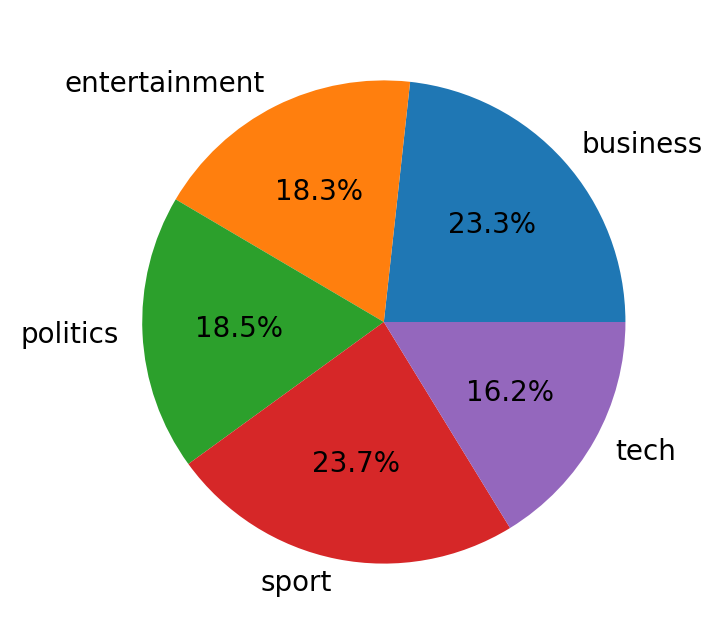

In [9]:
# lets now analyze various news categories and their corresponding numbers
plt.figure(dpi=200)
plt.pie(x=news.groupby(['Category']).count()['Text'],labels=news.groupby(['Category']).count().index, autopct='%1.1f%%');

We have <b>5 different categories</b> of <b>sport</b>, <b>business</b>, <b>politics</b>, <b>entertainment</b> and <b>tech</b>. The dataset is quite balanced with more or less equal representation from different categories.

# <font color='navy'><u>Data Preprocessing</u></font>

In [10]:
# first we're doing the train_test_split
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test=train_test_split(news.Text, news.Category, test_size=0.3, random_state=101)

# <font color='navy'><u>Document Vectorization</u></font>
Here we are going to <b>vectorize</b> all the <b>documents</b> in the training set

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# removing the stop words
vec=CountVectorizer(stop_words='english')

In [14]:
# vectorizing the training set
vec.fit(X_train)

CountVectorizer(stop_words='english')

In [15]:
vocab=list(vec.vocabulary_.keys())
vocab.sort()
len(vocab)

20653

There are <b>20653 words</b> in our <b>vocabulary</b>

In [16]:
# we're transforming our training set
X_train_trans=vec.transform(X_train)

In [17]:
# here's the compressed sparse row format of our training set
print(X_train_trans)

  (0, 1)	1
  (0, 106)	1
  (0, 329)	1
  (0, 373)	1
  (0, 483)	1
  (0, 533)	1
  (0, 1417)	2
  (0, 1763)	1
  (0, 2187)	1
  (0, 2411)	1
  (0, 2439)	1
  (0, 2555)	1
  (0, 2646)	1
  (0, 2701)	3
  (0, 2703)	1
  (0, 3207)	1
  (0, 3370)	1
  (0, 3408)	1
  (0, 3462)	2
  (0, 3582)	1
  (0, 3737)	1
  (0, 3754)	1
  (0, 3882)	1
  (0, 4065)	1
  (0, 4067)	1
  :	:
  (1007, 15938)	1
  (1007, 16101)	1
  (1007, 16173)	2
  (1007, 16174)	1
  (1007, 16393)	1
  (1007, 16637)	1
  (1007, 16656)	2
  (1007, 17009)	6
  (1007, 17011)	1
  (1007, 17021)	1
  (1007, 17300)	2
  (1007, 17310)	1
  (1007, 18086)	2
  (1007, 18349)	1
  (1007, 18848)	1
  (1007, 18862)	1
  (1007, 18888)	1
  (1007, 19085)	1
  (1007, 19173)	1
  (1007, 19276)	2
  (1007, 20077)	1
  (1007, 20141)	1
  (1007, 20145)	1
  (1007, 20180)	1
  (1007, 20495)	1


# <font color='navy'><u>Bag Of Words Representation</u></font>
Here's the <b>bag of words</b> representation of our training set. Though we can feed in both the <b>compressed sparse row format</b> or the entire <b>sparse matrix</b> into our <b>Naive Bayes</b> model. We choose <b>compressed sparse row format</b> due to its computational efficiency

In [18]:
pd.DataFrame(X_train_trans.toarray(), columns=vocab)

,00,000,000bn,000m,000th,001,001and,001st,0051,007,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1005,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# <font color='navy'><u>Model Building</u></font>
# <font color='darkgreen'>Building a Multinomial Naive Bayes Model: mnb</font>

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
mnb=MultinomialNB()

In [21]:
# fitting the transformed training data on the above multinomialNB object
mnb.fit(X_train_trans,y_train)

MultinomialNB()

In [22]:
# making predictions off of the training data using the above multinomialNB model
y_train_pred=mnb.predict(X_train_trans)
y_train_pred

array(['politics', 'entertainment', 'business', ..., 'business', 'sport',
       'entertainment'], dtype='<U13')

Importing all the relevant <b>classification metrics</b> to evaluate the performance on the training data and eventually the testing data

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

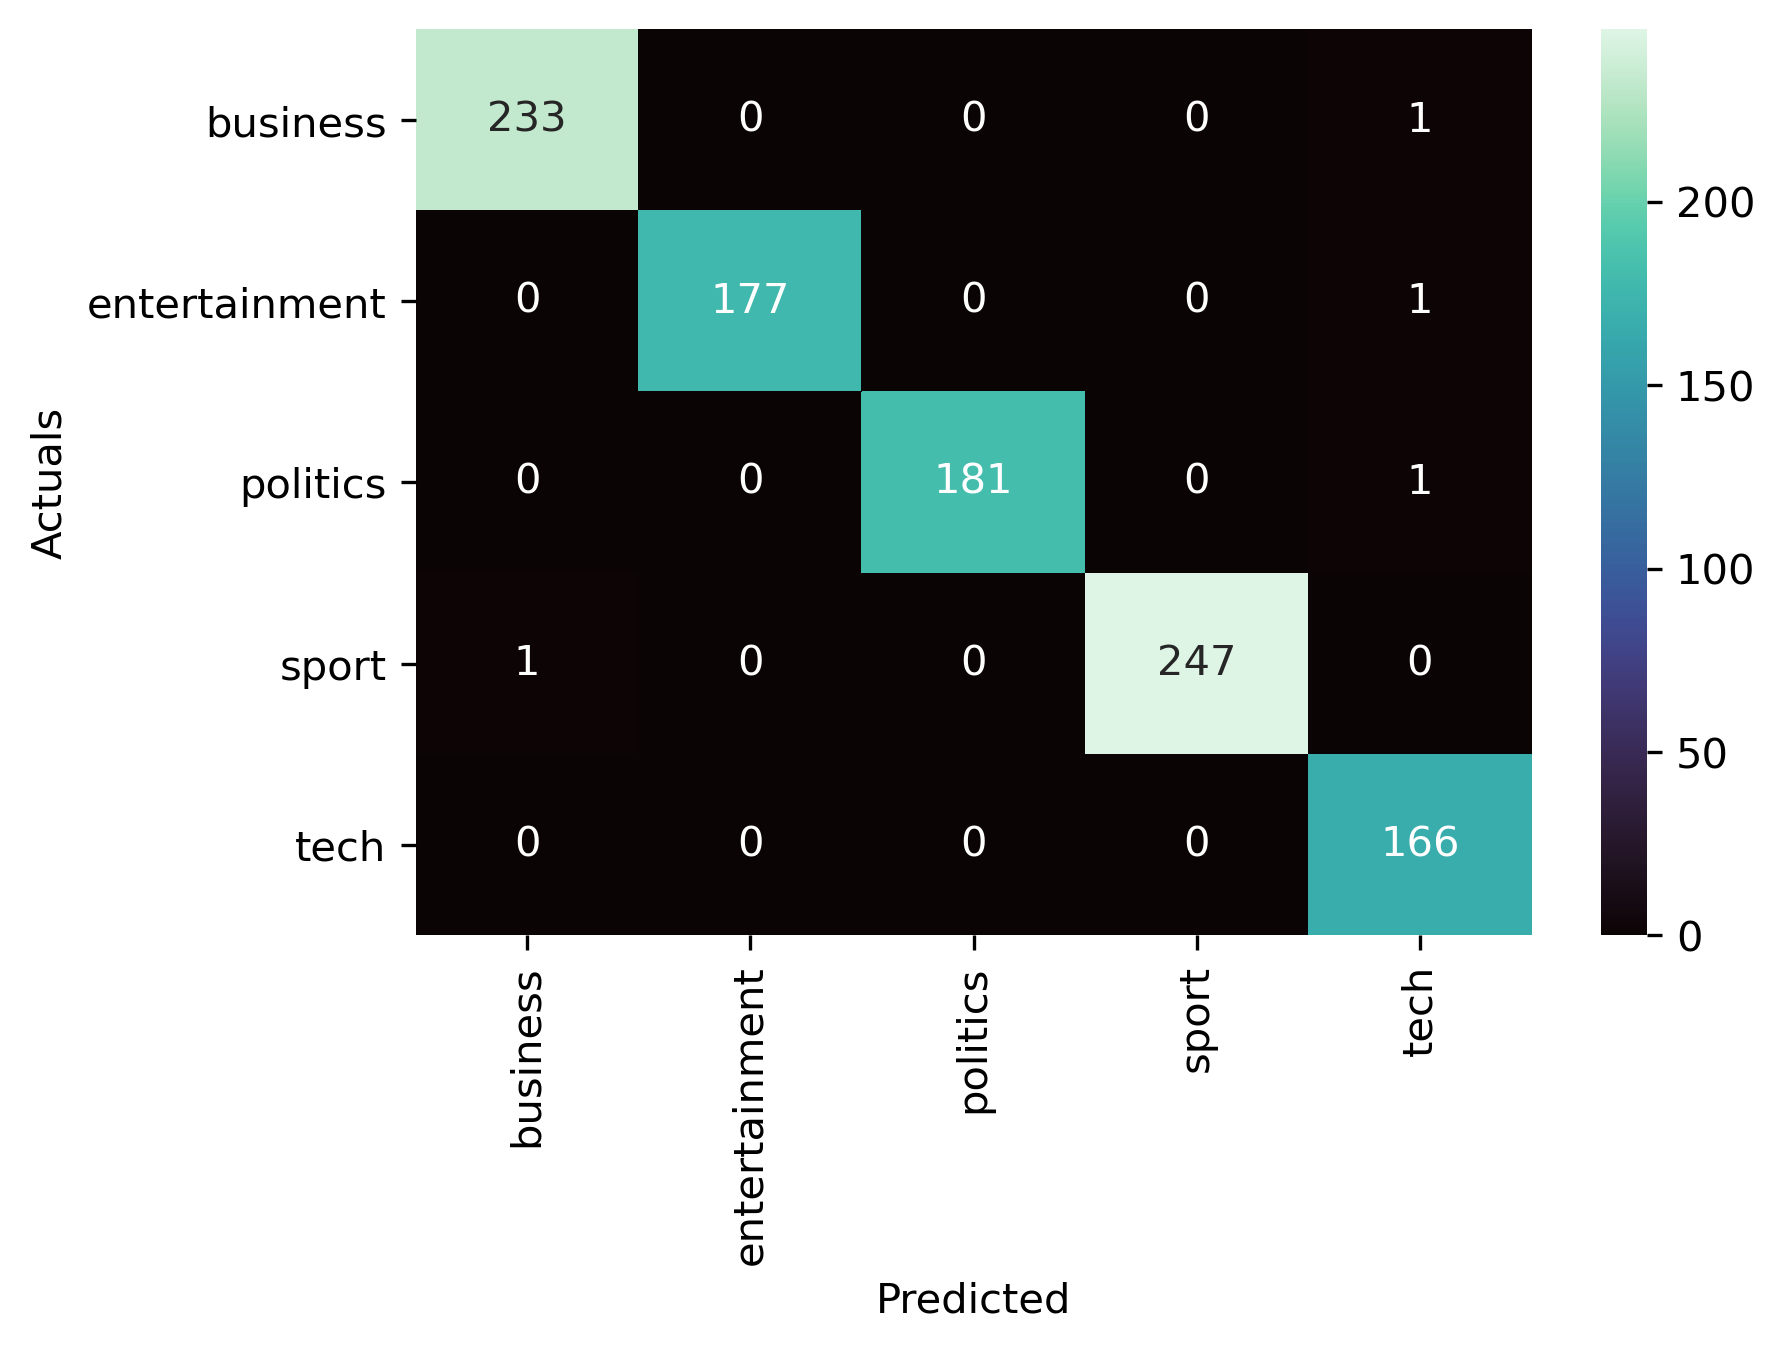

In [24]:
cate=news.Category.unique()
cate.sort()
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y_train,y_train_pred), annot=True, cmap='mako', fmt='.5g', xticklabels=cate, yticklabels=cate)
plt.xlabel('Predicted')
plt.ylabel('Actuals');

The above <b>confusion matrix</b> looks pretty good. Most of the articles in the training set are correctly categorized. Let us now check the other metrics both class-wise and global.

In [25]:
print(classification_report(y_train,y_train_pred))

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       234
entertainment       1.00      0.99      1.00       178
     politics       1.00      0.99      1.00       182
        sport       1.00      1.00      1.00       248
         tech       0.98      1.00      0.99       166

     accuracy                           1.00      1008
    macro avg       1.00      1.00      1.00      1008
 weighted avg       1.00      1.00      1.00      1008



All the important metrics such as <b>precision</b>, <b>recall</b> and <b>f1-score</b> both class-wise and global are pretty high

In [26]:
# computing the exact accuracy_score
accuracy_train=round(100*accuracy_score(y_train,y_train_pred),2)
print(f'The exact accuracy score is {accuracy_train}%')

The exact accuracy score is 99.6%


Now we are going to <b>vectorize</b> the <b>testing set</b> to make inference using the above <b>MultinomialNB</b> we created

In [27]:
# we're transforming our testing set
X_test_trans=vec.transform(X_test)

In [28]:
# here's the compressed sparse row format of our testing set
print(X_test_trans)

  (0, 162)	1
  (0, 186)	1
  (0, 1030)	2
  (0, 1743)	1
  (0, 1914)	1
  (0, 2364)	3
  (0, 2456)	2
  (0, 2457)	3
  (0, 3797)	1
  (0, 3898)	2
  (0, 4197)	1
  (0, 4201)	1
  (0, 4935)	1
  (0, 5389)	1
  (0, 6277)	1
  (0, 6281)	1
  (0, 6563)	1
  (0, 6779)	1
  (0, 6780)	1
  (0, 6971)	1
  (0, 7004)	1
  (0, 7392)	1
  (0, 7456)	1
  (0, 7585)	1
  (0, 8168)	1
  :	:
  (431, 14804)	1
  (431, 14959)	1
  (431, 15885)	1
  (431, 16102)	1
  (431, 16158)	1
  (431, 16292)	1
  (431, 16480)	2
  (431, 16637)	1
  (431, 17494)	1
  (431, 17510)	1
  (431, 17628)	1
  (431, 17654)	2
  (431, 17938)	1
  (431, 17942)	1
  (431, 17970)	1
  (431, 18145)	2
  (431, 18921)	1
  (431, 19201)	1
  (431, 19270)	7
  (431, 19630)	2
  (431, 19631)	2
  (431, 19641)	1
  (431, 20136)	1
  (431, 20316)	1
  (431, 20541)	1


In [29]:
# making predictions off of the testing data using the above multinomialNB model
y_test_pred=mnb.predict(X_test_trans)
y_test_pred

array(['sport', 'business', 'tech', 'entertainment', 'business', 'sport',
       'tech', 'politics', 'politics', 'tech', 'entertainment', 'tech',
       'sport', 'business', 'entertainment', 'politics', 'politics',
       'business', 'politics', 'sport', 'business', 'politics', 'sport',
       'politics', 'sport', 'entertainment', 'sport', 'sport', 'politics',
       'business', 'sport', 'politics', 'sport', 'politics', 'tech',
       'tech', 'business', 'tech', 'entertainment', 'sport',
       'entertainment', 'politics', 'sport', 'sport', 'politics',
       'politics', 'business', 'business', 'entertainment', 'tech',
       'politics', 'sport', 'business', 'tech', 'business', 'business',
       'entertainment', 'entertainment', 'entertainment', 'sport',
       'sport', 'sport', 'sport', 'entertainment', 'politics',
       'entertainment', 'entertainment', 'business', 'tech', 'business',
       'entertainment', 'tech', 'business', 'business', 'tech',
       'politics', 'business', 'po

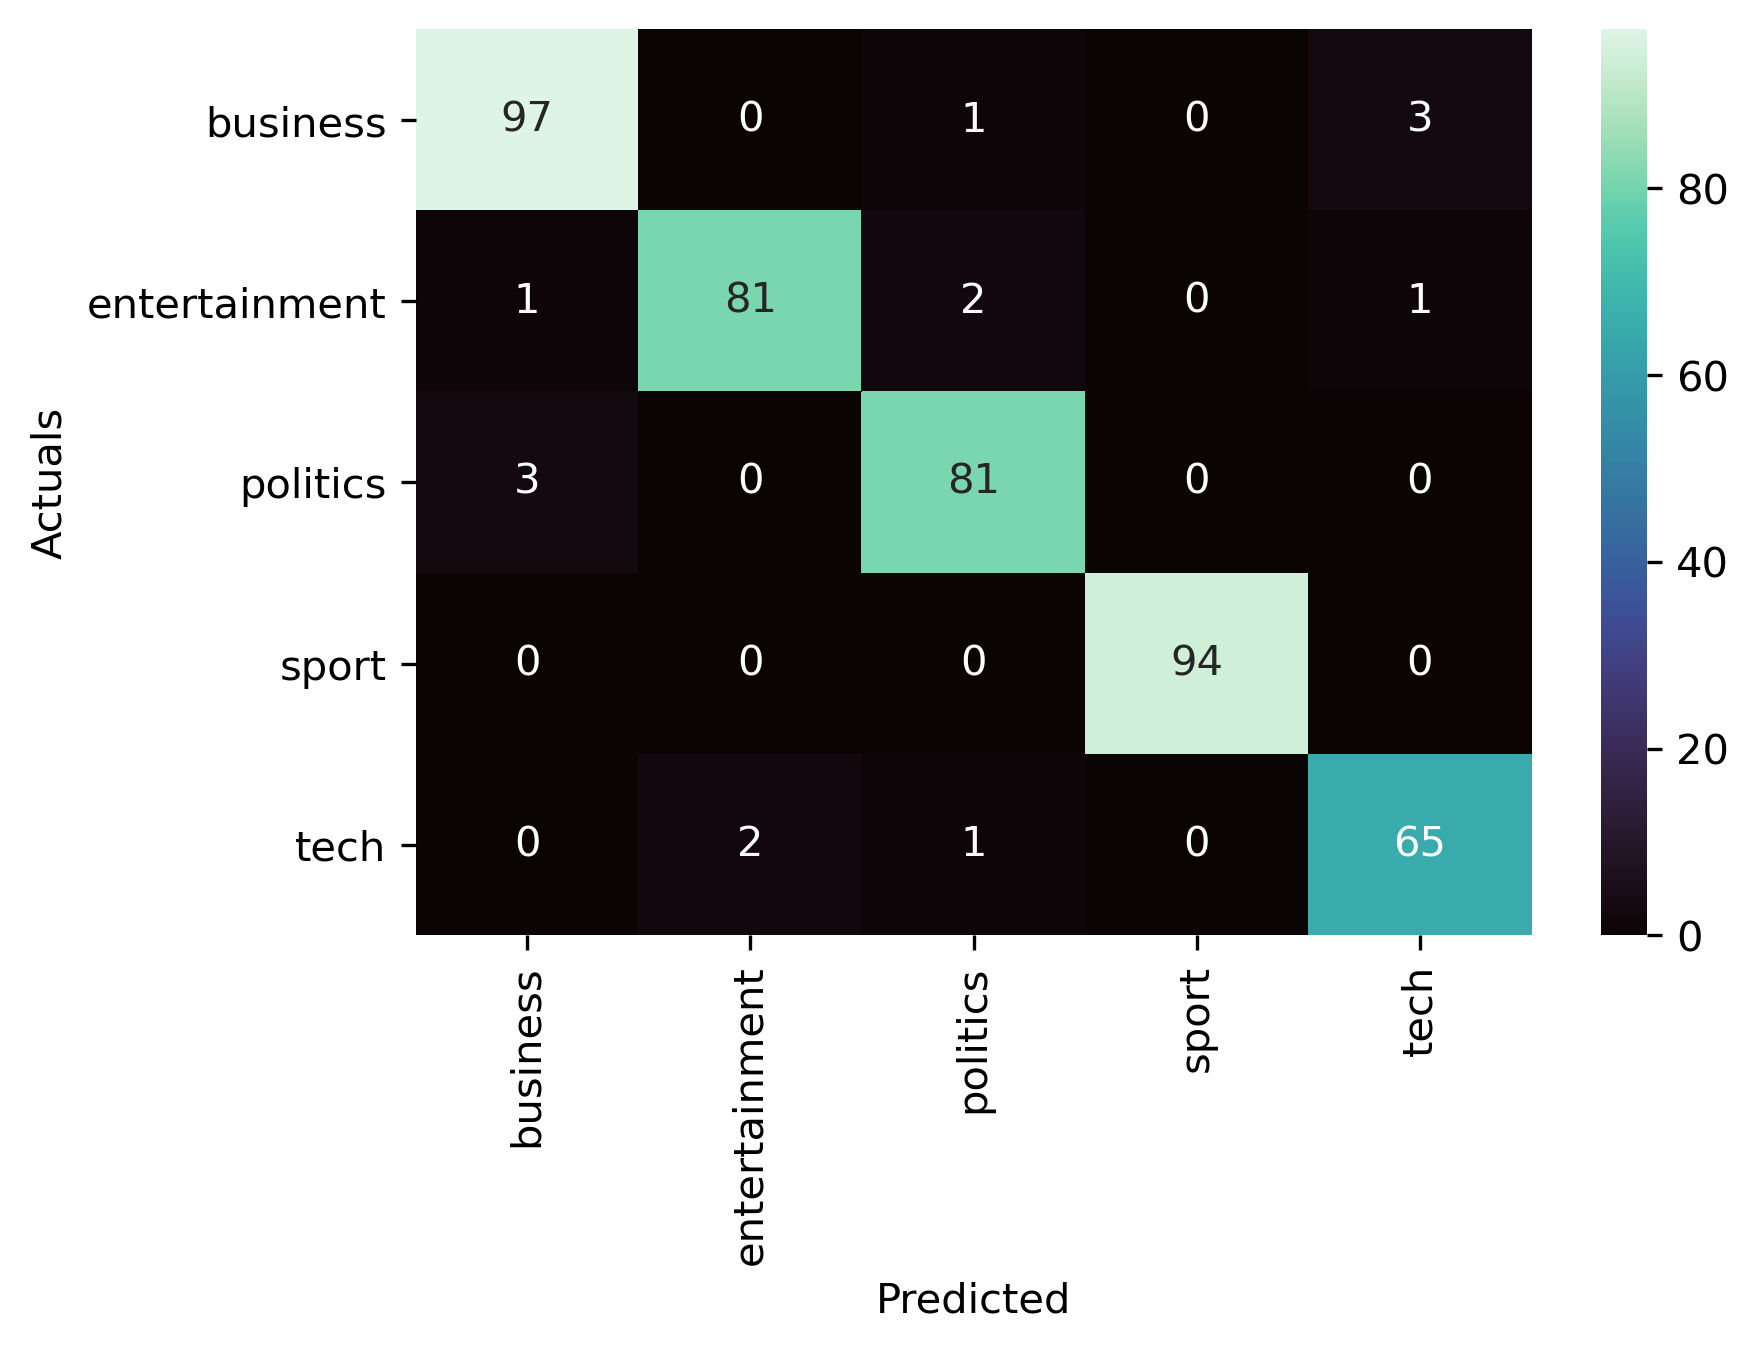

In [30]:
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y_test,y_test_pred), annot=True, cmap='mako', fmt='.5g', xticklabels=cate, yticklabels=cate)
plt.xlabel('Predicted')
plt.ylabel('Actuals');

The above <b>confusion matrix</b> looks pretty good. Most of the articles in the testing set are correctly categorized. Let us now check the other metrics both class-wise and global.

In [31]:
print(classification_report(y_test,y_test_pred))

               precision    recall  f1-score   support

     business       0.96      0.96      0.96       101
entertainment       0.98      0.95      0.96        85
     politics       0.95      0.96      0.96        84
        sport       1.00      1.00      1.00        94
         tech       0.94      0.96      0.95        68

     accuracy                           0.97       432
    macro avg       0.97      0.97      0.97       432
 weighted avg       0.97      0.97      0.97       432



All the important metrics such as <b>precision</b>, <b>recall</b> and <b>f1-score</b> both class-wise and global are pretty high

In [32]:
# computing the exact accuracy_score
accuracy_test=round(100*accuracy_score(y_test,y_test_pred),2)
print(f'The exact accuracy score is {accuracy_test}%')

The exact accuracy score is 96.76%


# <font color='darkviolet'>mnb Model Performance:</font>
<font color='darkviolet'><b>accuracy_train = 99.6%</b></font><br>
<font color='darkviolet'><b>accuracy_test = 96.76%</b></font><br>
Here we can clearly see that the <b>accuracy_score</b> of the test_set is quite close to that of the train_set which means that our <b>multinomial naive bayes model <font color='darkgreen'>mnb</font></b> is generalizing well to the unseen data. Now let us build another model

# <font color='darkgreen'>Building a Bernoulli Naive Bayes Model: bnb</font>

In [33]:
from sklearn.naive_bayes import BernoulliNB

In [34]:
bnb=BernoulliNB()

We've already <b>vectorized</b> both the <b>training set</b> and the <b>testing set</b>. We can use the same transformed data in this new model as well. So there won't be any changes in the <b>vocabulary</b> or the <b>bag of words</b> representation of the corpus

In [35]:
# fitting the transformed training data on the above bernoulliNB object
bnb.fit(X_train_trans,y_train)

BernoulliNB()

In [36]:
# making predictions off of the training data using the above bernoulliNB model
y_train_pred_bnb=bnb.predict(X_train_trans)
y_train_pred_bnb

array(['politics', 'entertainment', 'business', ..., 'business', 'sport',
       'entertainment'], dtype='<U13')

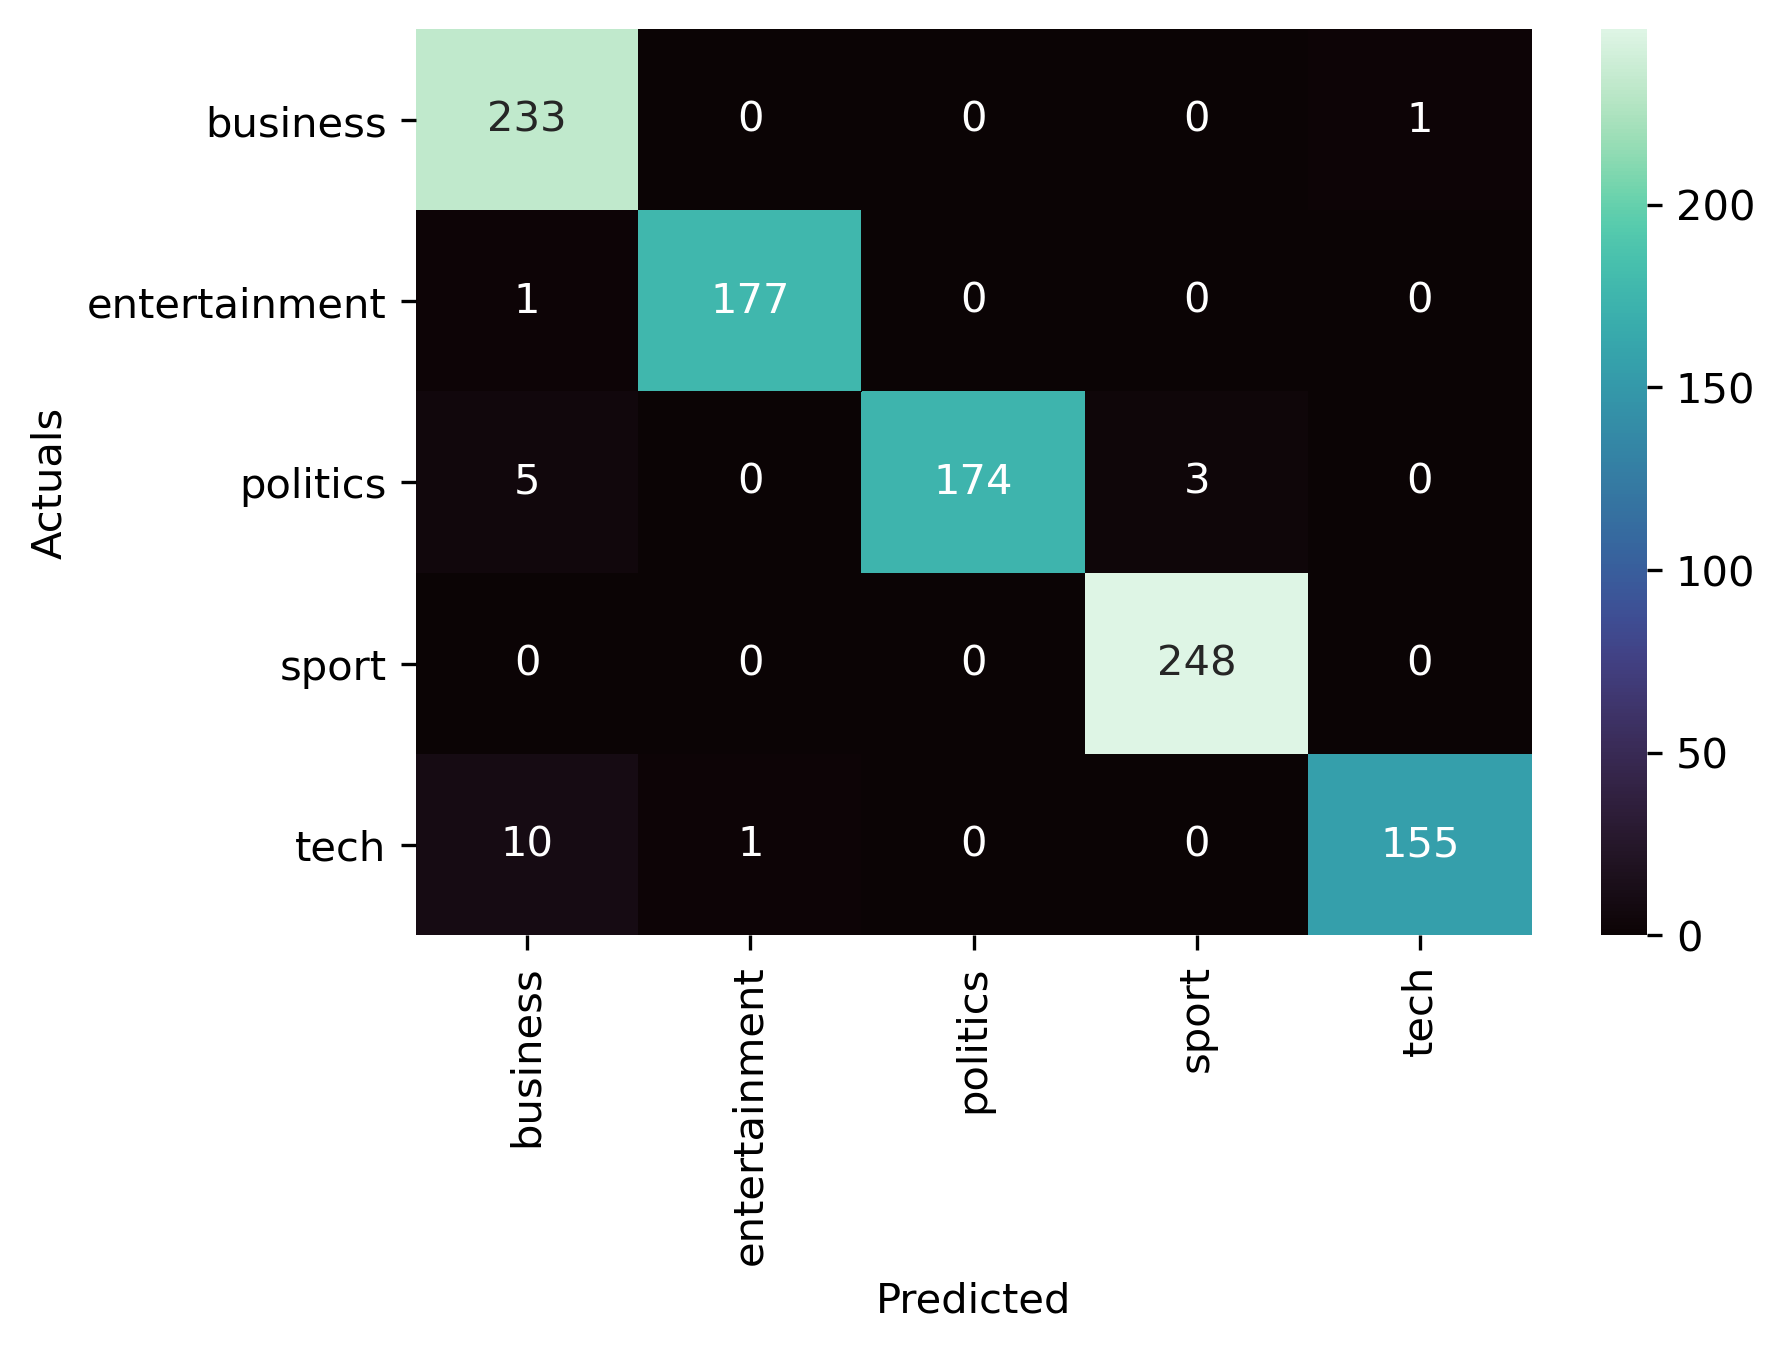

In [37]:
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y_train,y_train_pred_bnb), annot=True, cmap='mako', fmt='.5g', xticklabels=cate, yticklabels=cate)
plt.xlabel('Predicted')
plt.ylabel('Actuals');

The above <b>confusion matrix</b> looks pretty good. Most of the articles in the training set are correctly categorized. Let us now check the other metrics both class-wise and global.

In [38]:
print(classification_report(y_train,y_train_pred_bnb))

               precision    recall  f1-score   support

     business       0.94      1.00      0.96       234
entertainment       0.99      0.99      0.99       178
     politics       1.00      0.96      0.98       182
        sport       0.99      1.00      0.99       248
         tech       0.99      0.93      0.96       166

     accuracy                           0.98      1008
    macro avg       0.98      0.98      0.98      1008
 weighted avg       0.98      0.98      0.98      1008



Though all the important metrics such as <b>precision</b>, <b>recall</b> and <b>f1-score</b> both class-wise and global are pretty high, there's a marginal dip in some of these metrics when compared to our previous model

In [39]:
# computing the exact accuracy_score
accuracy_train_bnb=round(100*accuracy_score(y_train,y_train_pred_bnb),2)
print(f'The exact accuracy score is {accuracy_train_bnb}%')

The exact accuracy score is 97.92%


In [40]:
# making predictions off of the testing data using the above bernoulliNB model
y_test_pred_bnb=bnb.predict(X_test_trans)
y_test_pred_bnb

array(['sport', 'business', 'business', 'sport', 'business', 'sport',
       'tech', 'politics', 'politics', 'tech', 'entertainment', 'tech',
       'sport', 'business', 'entertainment', 'politics', 'politics',
       'business', 'politics', 'sport', 'business', 'politics', 'sport',
       'politics', 'sport', 'entertainment', 'sport', 'sport', 'politics',
       'business', 'sport', 'politics', 'sport', 'politics', 'tech',
       'tech', 'business', 'business', 'entertainment', 'sport',
       'entertainment', 'politics', 'sport', 'sport', 'politics',
       'politics', 'business', 'business', 'entertainment', 'tech',
       'politics', 'sport', 'business', 'business', 'business',
       'business', 'entertainment', 'entertainment', 'entertainment',
       'sport', 'sport', 'sport', 'sport', 'business', 'sport',
       'entertainment', 'entertainment', 'business', 'tech', 'business',
       'entertainment', 'tech', 'business', 'business', 'business',
       'politics', 'business', 'po

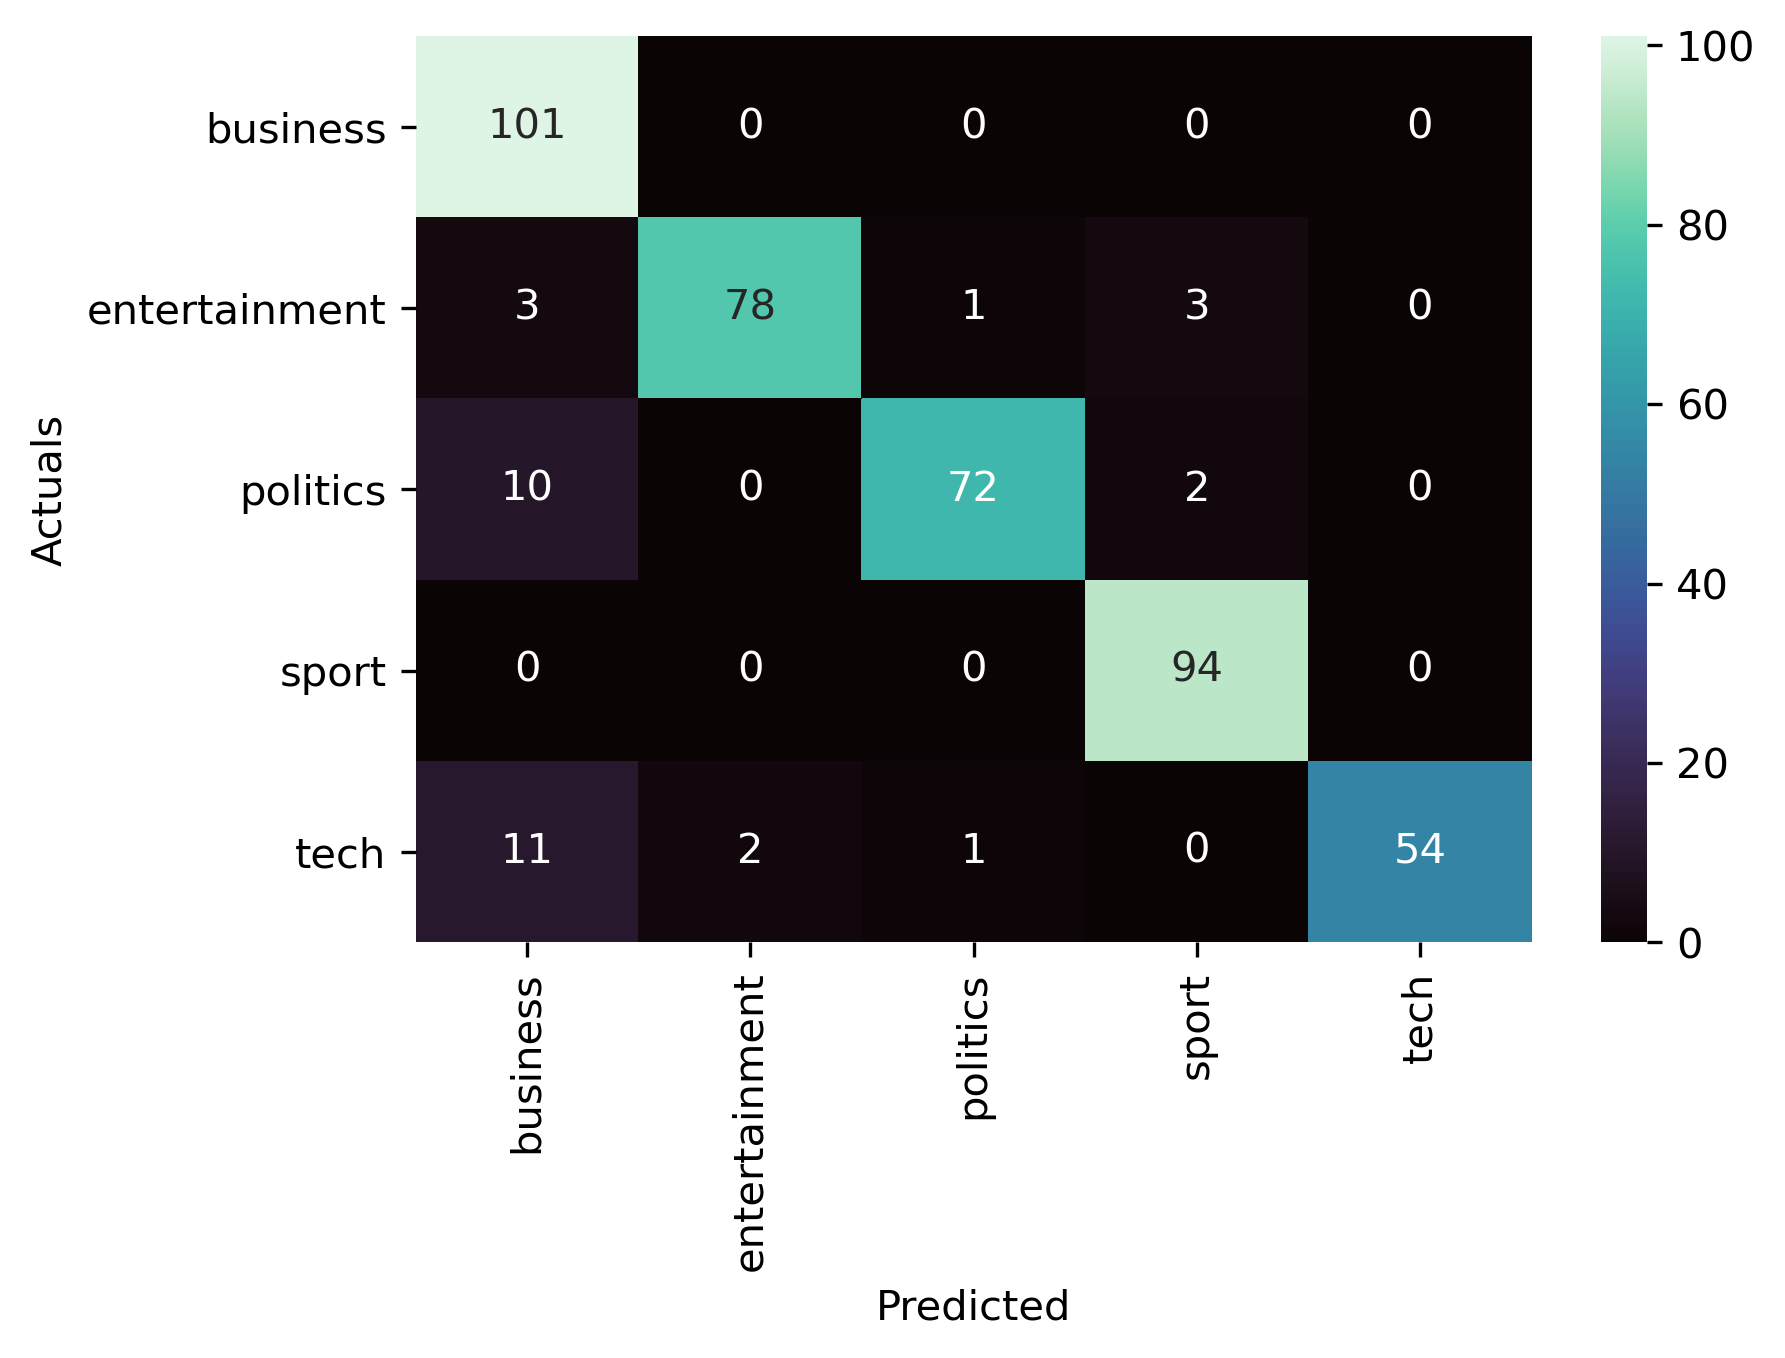

In [41]:
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y_test,y_test_pred_bnb), annot=True, cmap='mako', fmt='.5g', xticklabels=cate, yticklabels=cate)
plt.xlabel('Predicted')
plt.ylabel('Actuals');

The above <b>confusion matrix</b> looks pretty good. Most of the articles in the testing set are correctly categorized. Let us now check the other metrics both class-wise and global.

In [42]:
print(classification_report(y_test,y_test_pred_bnb))

               precision    recall  f1-score   support

     business       0.81      1.00      0.89       101
entertainment       0.97      0.92      0.95        85
     politics       0.97      0.86      0.91        84
        sport       0.95      1.00      0.97        94
         tech       1.00      0.79      0.89        68

     accuracy                           0.92       432
    macro avg       0.94      0.91      0.92       432
 weighted avg       0.93      0.92      0.92       432



Though all the important metrics such as <b>precision</b>, <b>recall</b> and <b>f1-score</b> both class-wise and global are high, there's a noticeable dip in some of these metrics when compared to our previous model

In [43]:
# computing the exact accuracy_score
accuracy_test_bnb=round(100*accuracy_score(y_test,y_test_pred_bnb),2)
print(f'The exact accuracy score is {accuracy_test_bnb}%')

The exact accuracy score is 92.36%


# <font color='darkviolet'>bnb Model Performance:</font>
<font color='darkviolet'><b>accuracy_train = 97.92%</b></font><br>
<font color='darkviolet'><b>accuracy_test = 92.36%</b></font><br>
Here we can clearly see that the <b>accuracy_score</b> of the test_set is quite close to that of the train_set which means that our <b>bernoulli naive bayes model <font color='darkgreen'>bnb</font></b> is generalizing well to the unseen data

# <font color='darkgreen'>Model Comparison:</font>

In [44]:
comparison={'accuracy_score':['train_set','test_set'],
            'mnb':['99.6%', '96.76%'], 'bnb':['97.92%','92.36%']}
pd.DataFrame(comparison).set_index(['accuracy_score'])

,mnb,bnb
accuracy_score,,
train_set,99.6%,97.92%
test_set,96.76%,92.36%


Based on the performance metrics, we can conclude that <font color='darkgreen'><b>mnb</b></font> is a better classifier than <font color='darkgreen'><b>bnb</b></font>. So let us build our final model using <b>multinomial naive bayes</b> classifier. Also this time let us take full advantage of the entire data set by combining training and testing set and build a model off of it

# <font color='darkgreen'>Building Final Model: final_mnb</font>
Since we're using the entire dataset in this model building, we will have to <b>transform</b> our data once again. Because when we use a different dataset, there are very high chances of obtaining new <b>vocabulary</b>, <b>vectorization</b> and <b>bag of words</b> representation

In [45]:
# using the entire data 
X=news.Text
y=news.Category

Here we are going to <b>vectorize</b> all the <b>documents</b> in the entire dataset

In [46]:
# creating a new vectorizer and removing the stop words
vector=CountVectorizer(stop_words='english')

In [47]:
# vectorizing the entire dataset
vector.fit(X)

CountVectorizer(stop_words='english')

In [48]:
voc=list(vector.vocabulary_.keys())
voc.sort()
len(voc)

24456

There are <b>24456 words</b> in our <b>vocabulary</b>

In [49]:
# we're transforming our dataset
X_trans=vector.transform(X)

In [50]:
# here's the compressed sparse row format of our dataset
print(X_trans)

  (0, 100)	1
  (0, 402)	2
  (0, 405)	2
  (0, 407)	1
  (0, 1009)	1
  (0, 1040)	1
  (0, 1076)	1
  (0, 1336)	7
  (0, 1472)	1
  (0, 1645)	1
  (0, 1749)	1
  (0, 1750)	1
  (0, 1980)	2
  (0, 2083)	1
  (0, 2198)	1
  (0, 2258)	1
  (0, 2260)	1
  (0, 2331)	1
  (0, 2549)	1
  (0, 2555)	2
  (0, 2843)	1
  (0, 2965)	1
  (0, 3191)	1
  (0, 3571)	1
  (0, 3616)	1
  :	:
  (1439, 20935)	2
  (1439, 21109)	1
  (1439, 21347)	1
  (1439, 21728)	1
  (1439, 21871)	2
  (1439, 22025)	1
  (1439, 22097)	1
  (1439, 22127)	1
  (1439, 22217)	1
  (1439, 23158)	1
  (1439, 23241)	1
  (1439, 23242)	3
  (1439, 23252)	1
  (1439, 23335)	1
  (1439, 23452)	1
  (1439, 23526)	2
  (1439, 23536)	1
  (1439, 23617)	1
  (1439, 23618)	1
  (1439, 23824)	1
  (1439, 23829)	1
  (1439, 23830)	3
  (1439, 23969)	1
  (1439, 24190)	5
  (1439, 24203)	1


# <font color='navy'><u>Bag Of Words Representation</u></font>
Here's the <b>bag of words</b> representation of our entire dataset

In [51]:
pd.DataFrame(X_trans.toarray(), columns=voc)

,00,000,0001,000bn,000m,000th,001,001and,001st,0051,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# creating a new multinomialNB model object
final_mnb=MultinomialNB()

In [53]:
# fitting the transformed data on the above multinomialNB object
final_mnb.fit(X_trans,y)

MultinomialNB()

In [54]:
# making predictions off of the dataset using the above multinomialNB model
y_pred=final_mnb.predict(X_trans)
y_pred

array(['business', 'business', 'business', ..., 'business', 'tech',
       'tech'], dtype='<U13')

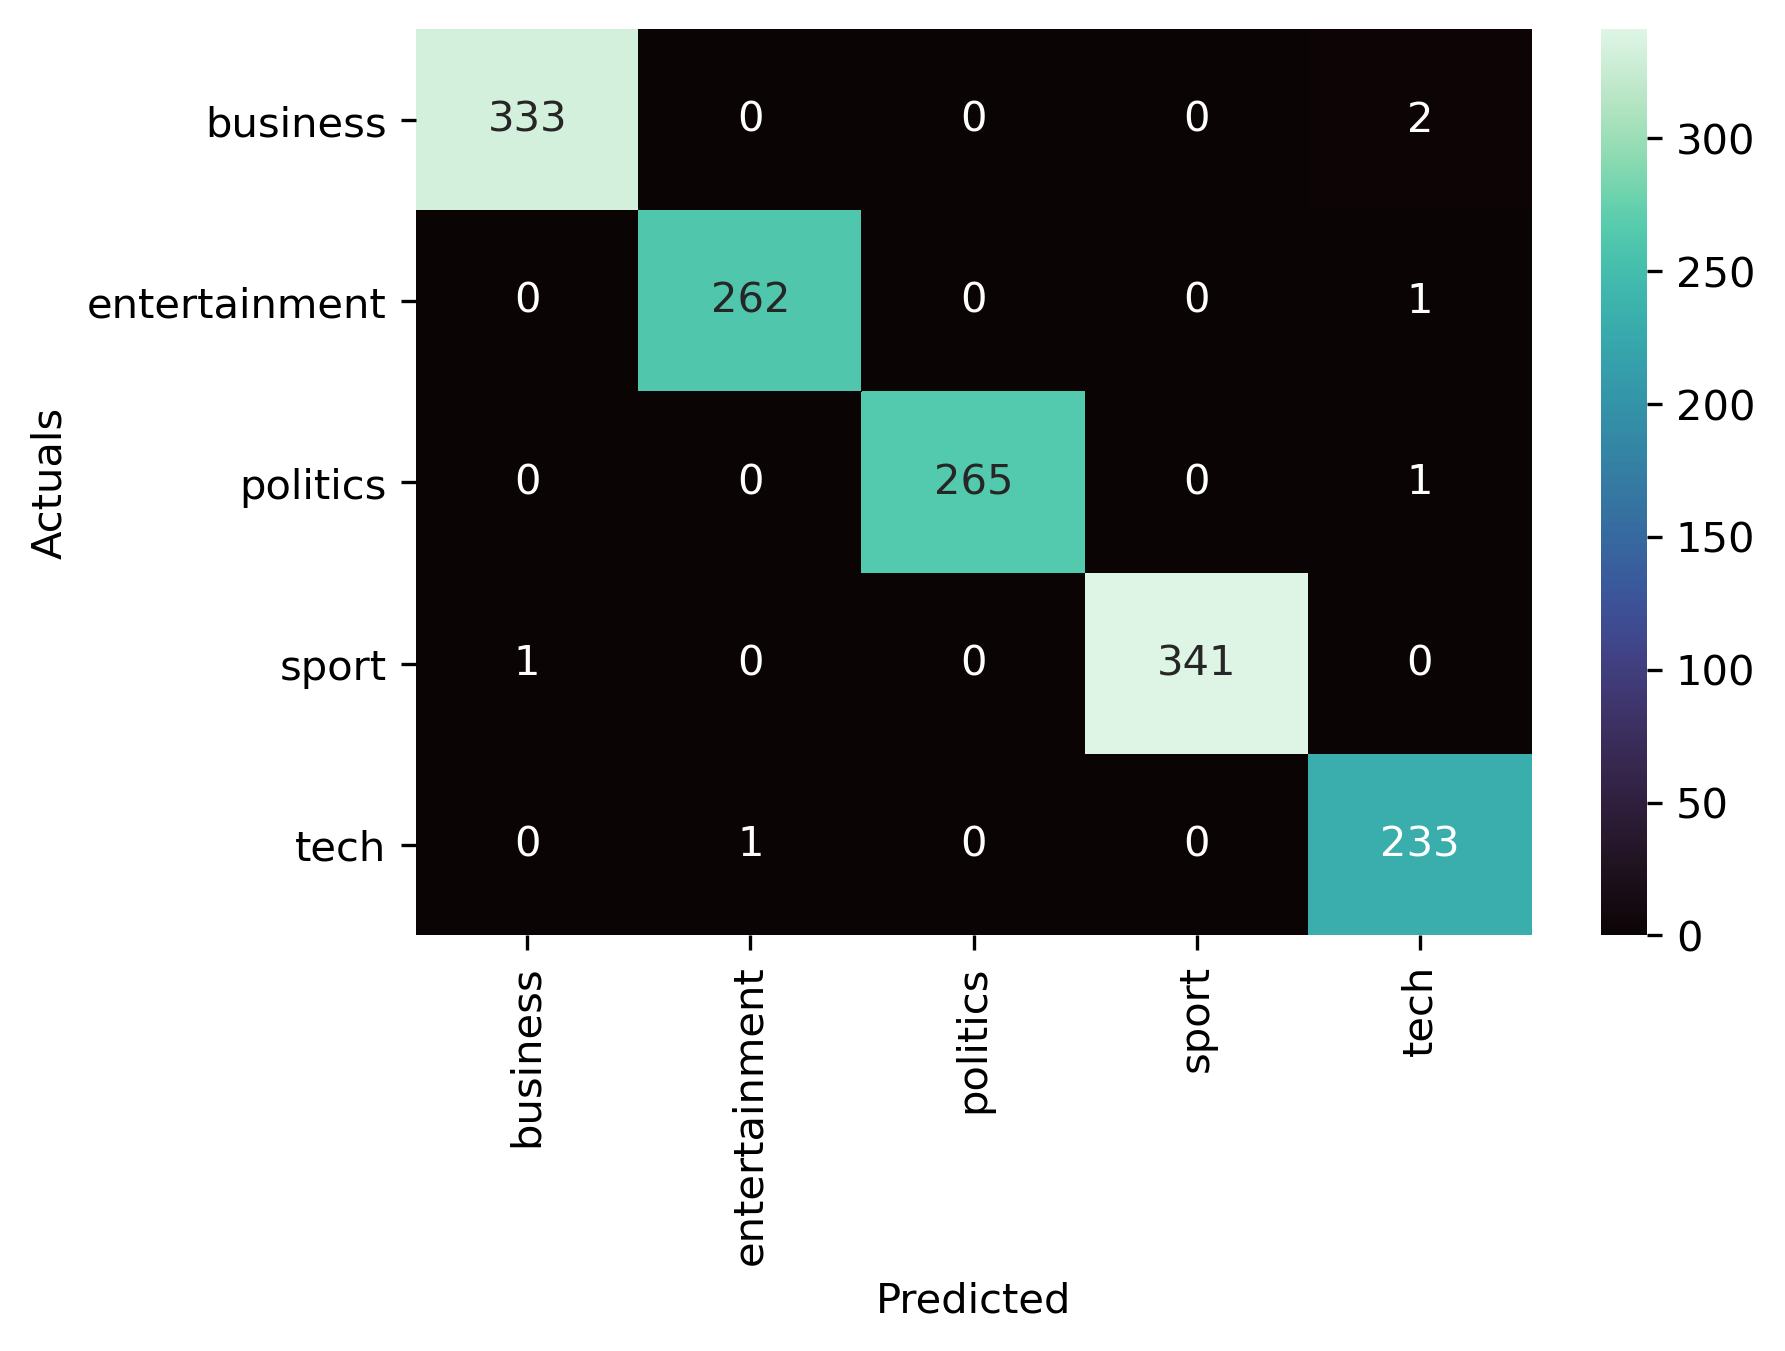

In [55]:
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y,y_pred), annot=True, cmap='mako', fmt='.5g', xticklabels=cate, yticklabels=cate)
plt.xlabel('Predicted')
plt.ylabel('Actuals');

The above confusion matrix looks pretty good. Most of the articles in the dataset are correctly categorized. Let us now check the other metrics both class-wise and global.

In [56]:
print(classification_report(y,y_pred))

               precision    recall  f1-score   support

     business       1.00      0.99      1.00       335
entertainment       1.00      1.00      1.00       263
     politics       1.00      1.00      1.00       266
        sport       1.00      1.00      1.00       342
         tech       0.98      1.00      0.99       234

     accuracy                           1.00      1440
    macro avg       1.00      1.00      1.00      1440
 weighted avg       1.00      1.00      1.00      1440



All the important metrics such as <b>precision</b>, <b>recall</b> and <b>f1-score</b> both class-wise and global are pretty high

In [57]:
# computing the exact accuracy_score
accuracy_final=round(100*accuracy_score(y,y_pred),2)
print(f'The exact accuracy score is {accuracy_final}%')

The exact accuracy score is 99.58%


# <font color='darkviolet'>bnb Model Performance:</font>
<font color='darkviolet'><b>accuracy_final = 99.58%</b></font><br>
This is clearly a very high <b>accuracy_score</b> for a classification problem

Let us now predict <b>Category</b> of totally unseen dataset which was not used at any stage of the any of the models we've built above. Note that the following dataset is <b>unlabelled</b> which means that there's no way we can check its <b>accuracy_score</b> or any other <b>classification metrics</b>. 
We will have to apply our human judgement to determine the quality of prediction

In [58]:
unlabelled=pd.read_csv('BBC News Test.csv')

In [59]:
unlabelled

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


There are <b>735</b> new documents in the above dataframe and as mentioned already <b>ArticleId</b> is useless in making predictions, so we'll drop it and then try to predict the <b>Category</b> of these news article and concatenate with the original <b>unlabelled</b> dataframe

In [60]:
# extracting only the text column
un_X=unlabelled.Text

In [61]:
# vectorizing the documents using the same vectorizer object created for our final_mnb model
un_X_trans=vector.transform(un_X)
un_X_trans

<735x24456 sparse matrix of type '<class 'numpy.int64'>'
	with 102742 stored elements in Compressed Sparse Row format>

In [62]:
# making predictions off of the unlabelled dataset
un_y_pred=final_mnb.predict(un_X_trans)
un_y_pred

array(['sport', 'tech', 'sport', 'business', 'sport', 'sport', 'politics',
       'politics', 'entertainment', 'business', 'business', 'tech',
       'politics', 'tech', 'entertainment', 'sport', 'politics', 'tech',
       'entertainment', 'entertainment', 'business', 'politics', 'sport',
       'business', 'politics', 'sport', 'business', 'sport', 'sport',
       'business', 'politics', 'tech', 'business', 'business', 'sport',
       'sport', 'sport', 'business', 'entertainment', 'entertainment',
       'tech', 'politics', 'entertainment', 'tech', 'sport', 'tech',
       'entertainment', 'business', 'politics', 'business', 'politics',
       'business', 'business', 'business', 'tech', 'politics', 'tech',
       'entertainment', 'sport', 'tech', 'sport', 'entertainment', 'tech',
       'politics', 'business', 'entertainment', 'sport', 'tech', 'sport',
       'sport', 'tech', 'sport', 'business', 'politics', 'tech', 'sport',
       'tech', 'tech', 'tech', 'entertainment', 'politics', 's

In [63]:
# concatenating the above predicted cateogories with original unlabelled dataset
unlabelled['Predicted_Category']=un_y_pred

In [64]:
unlabelled

,ArticleId,Text,Predicted_Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,business
731,373,u2 to play at grammy awards show irish rock ba...,entertainment
732,1704,sport betting rules in spotlight a group of mp...,politics
733,206,alfa romeos to get gm engines fiat is to sto...,business


Since we can't read the full story in the above dataframe, let us randomly pick an article or two and check its predicted_category

In [65]:
unlabelled.iloc[101,1]

'ruddock backs yapp s credentials wales coach mike ruddock says john yapp has what it takes as an international.  the 21-year-old blues prop is the only uncapped player in wales  six nations squad  gaining a chance in the absence of ospreys loose-head duncan jones.  john is a young man with a big future. he has been playing with the blues for two years and has racked up mileage on his playing clock   said ruddock.  he has international size  is a big  physical lad and a good ball-carrier with a high tackle-count.  ruddock s assessment was backed up by yapp s coach at the blues  former wales and lions prop dai young.   john s been on an upward curve all season and is going from strength to strength   young told bbc sport wales.  his ball carrying gives us good go-forward  he impresses in defence and his work-rate is excellent.  he s working hard on his scrummaging technique  which he is keen to improve to become a destroyer on the loose-head.  to be fair to him he s not quite there with

In [66]:
unlabelled.iloc[101,2]

'sport'

The above prediction is correct

In [67]:
unlabelled.iloc[604,1]

'irish duo could block man utd bid irishmen jp mcmanus and john magnier  who own a 29% stake in manchester united  will reportedly reject any formal £800m offer for the club.  the sunday times and the sunday telegraph say they will oppose any formal £800m takeover bid from us tycoon malcom glazer. mr glazer got permission to look at the club s accounts last week. irish billionaires mr mcmanus and mr magnier are said to believe that an £800m bid undervalues club prospects.  mr magnier and mr mcmanus  who hold their stake through their cubic expression investment vehicle have the power to block a bid. mr glazer s financial backers  including jp morgan  the us investment bank have said they won t back a bid unless it receives backing from the owners of at least 75% of the club s shares. however  there has been much speculation that the irish duo simply do not think the price offered - 300p a share - is high enough. mr glazer has been stalking the premier league football club since 2003.  

In [68]:
unlabelled.iloc[604,2]

'business'

The above prediction is correct

# <font color='navy'><u>Custom UDF</u></font>
To make our task simpler in predicting the <b>Category</b> of any news article in future. We are creating a <b>custom udf</b> using our <b>final_mnb</b> model. It will predict a news article's most appropriate category from the following list of categories

- business
- entertainment
- politics
- sport
- tech

Limitations of the predictions: 
- obviously there's going to be language restriction, since this is modelled using dataset in English language
- this model classifies any news article to be in one of the above 5 categories even if they're not
- model can make decent predictions only by using the full-length article, not just the header of the article


In [69]:
def category():
    article=[input('Write (or paste) the news article here:\n\n')]
    article_trans=vector.transform(article)
    predicted=final_mnb.predict(article_trans)
    print(f'\nThis article belongs to the category: {predicted[0].upper()}')

In [70]:
# call this function and give your input
category()

Write (or paste) the news article here:

A father passes down a legacy of power, corruption and violence to his sons, one of whom rejects those values, only to take control with a ruthless contempt in order to preserve the family business. It's a uniquely American story that weaves in elements of assimilation, loyalty, sibling rivalry and quest for power, with a heavy dose of bloodletting.  "The Godfather" is that rare motion picture that satisfies the visceral desire for sensational entertainment, the emotional need for affecting drama, and the intellectual drive for art. Born from a mass market potboiler about the Mafia by an author desperate to make a few bucks, the resulting film version is one of the great American films about family - brought to life with vivid direction and craftsmanship and some of the best actors ever to appear on screen.  Premiering fifty years ago, on March 14, 1972, the film opened to blockbuster business and became a landmark, inspiring two film sequels, i